- SageMaker Studio Notebook
- Using PyTorch 2.0.1 Python 3.10 GPU optimized kernel with ml.g5dn.xlarge
- The scope is to detect people in a region and track each person with an ID
- This public video repository can be used: https://www.pexels.com/it-it/cerca/videos/people%20inside%20train/


In [20]:
!pip install ultralytics -qq

In [21]:
# Object Detecion 
import cv2
from ultralytics import YOLO
#plots
import matplotlib.pyplot as plt
import seaborn as sns

#basics
import pandas as pd
import numpy as np
import os
import subprocess

from tqdm.notebook import tqdm

# Display image and videos
import IPython
from IPython.display import Video, display
%matplotlib inline


import urllib.request 
import shutil


In [22]:
!ls

PeopleTrackingYolo.ipynb  rep_result_original.mp4  working
rep_result.mp4		  vid1.zip		   yolov8x.pt


In [35]:
# Video  path for experiment
path_zip = 'https://github.com/freedomwebtech/roiinyolo/raw/main/vid1.zip' # credits to the github repo for the video
urllib.request.urlretrieve(path_zip, "vid1.zip")
shutil.unpack_archive('vid1.zip', 'working/')

#path = 'working/vid1.mp4'
path = 'working/vid1.mp4'

In [24]:
#loading a YOLO model 
model = YOLO('yolov8x.pt')

#geting names from classes
dict_classes = model.model.names

In [25]:
# Auxiliary functions
def risize_frame(frame, scale_percent):
    """Function to resize an image in a percent scale"""
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    return resized



def filter_tracks(centers, patience):
    """Function to filter track history"""
    filter_dict = {}
    for k, i in centers.items():
        d_frames = i.items()
        filter_dict[k] = dict(list(d_frames)[-patience:])

    return filter_dict


def update_tracking(centers_old,obj_center, thr_centers, lastKey, frame, frame_max):
    """Function to update track of objects"""
    is_new = 0
    lastpos = [(k, list(center.keys())[-1], list(center.values())[-1]) for k, center in centers_old.items()]
    lastpos = [(i[0], i[2]) for i in lastpos if abs(i[1] - frame) <= frame_max]
    # Calculating distance from existing centers points
    previous_pos = [(k,obj_center) for k,centers in lastpos if (np.linalg.norm(np.array(centers) - np.array(obj_center)) < thr_centers)]
    # if distance less than a threshold, it will update its positions
    if previous_pos:
        id_obj = previous_pos[0][0]
        centers_old[id_obj][frame] = obj_center
    
    # Else a new ID will be set to the given object
    else:
        if lastKey:
            last = lastKey.split('D')[1]
            id_obj = 'ID' + str(int(last)+1)
        else:
            id_obj = 'ID0'
            
        is_new = 1
        centers_old[id_obj] = {frame:obj_center}
        lastKey = list(centers_old.keys())[-1]

    
    return centers_old, id_obj, is_new, lastKey

In [26]:
%pip install --upgrade --quiet jupyter_client ipywidgets
#%pip install IProgress
import ipywidgets


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
### Configurations
#Verbose during prediction
verbose = False
# Scaling percentage of original frame
scale_percent = 100
# model confidence level
conf_level = 0.8
# Threshold of centers ( old\new)
thr_centers = 20
#Number of max frames to consider a object lost 
frame_max = 5
# Number of max tracked centers stored 
patience = 100
# ROI area color transparency
alpha = 0.1
#-------------------------------------------------------
# Reading video with cv2
video = cv2.VideoCapture(path)

# Objects to detect Yolo
class_IDS = [0] 
# Auxiliary variables
centers_old = {}

obj_id = 0 
end = []
frames_list = []
count_p = 0
lastKey = ''
print(f'[INFO] - Verbose during Prediction: {verbose}')


# Original informations of video
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = video.get(cv2.CAP_PROP_FPS)
print('[INFO] - Original Dim: ', (width, height))

# Scaling Video for better performance 
if scale_percent != 100:
    print('[INFO] - Scaling change may cause errors in pixels lines ')
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    print('[INFO] - Dim Scaled: ', (width, height))
    

#-------------------------------------------------------
### Video output ####
video_name = 'result.mp4'
output_path = "rep_" + video_name
tmp_output_path = "tmp_" + output_path
VIDEO_CODEC = "MP4V"

output_video = cv2.VideoWriter(tmp_output_path, 
                               cv2.VideoWriter_fourcc(*VIDEO_CODEC), 
                               fps, (width, height))


#-------------------------------------------------------
# Executing Recognition 
for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):
    
    # reading frame from video
    _, frame = video.read()
    
    #Applying resizing of read frame
    frame  = risize_frame(frame, scale_percent)
#     frame  = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    area_roi = [np.array([ (1250, 400),(750,400),(700,800) ,(1200,800)], np.int32)]
    ROI = frame[390:800, 700:1300]
    #ROI = frame[400:800, 100:1600]
    #ROI = frame[100:700, 100:1000]

  
    if verbose:
        print('Dimension Scaled(frame): ', (frame.shape[1], frame.shape[0]))

    # Getting predictions
    y_hat = model.predict(ROI, conf = conf_level, classes = class_IDS, device = 0, verbose = False)
    
    # Getting the bounding boxes, confidence and classes of the recognize objects in the current frame.
    boxes   = y_hat[0].boxes.xyxy.cpu().numpy()
    conf    = y_hat[0].boxes.conf.cpu().numpy()
    classes = y_hat[0].boxes.cls.cpu().numpy() 
    
    # Storing the above information in a dataframe
    #positions_frame = pd.DataFrame(y_hat[0].cpu().numpy().boxes.boxes, columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])
    positions_frame = pd.DataFrame(y_hat[0].cpu().numpy().boxes.data, columns = ['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'class'])
    
    #Translating the numeric class labels to text
    labels = [dict_classes[i] for i in classes]
    
    
    # For each people, draw the bounding-box and counting each one the pass thought the ROI area
    for ix, row in enumerate(positions_frame.iterrows()):
        # Getting the coordinates of each vehicle (row)
        xmin, ymin, xmax, ymax, confidence, category,  = row[1].astype('int')
        
        # Calculating the center of the bounding-box
        center_x, center_y = int(((xmax+xmin))/2), int((ymax+ ymin)/2)
        
        #Updating the tracking for each object
        centers_old, id_obj, is_new, lastKey = update_tracking(centers_old, (center_x, center_y), thr_centers, lastKey, i, frame_max)
        

        #Updating people in roi
        count_p+=is_new
        
        # drawing center and bounding-box in the given frame 
        cv2.rectangle(ROI, (xmin, ymin), (xmax, ymax), (0,0,255), 2) # box
        for center_x,center_y in centers_old[id_obj].values():
            cv2.circle(ROI, (center_x,center_y), 5,(0,0,255),-1) # center of box
        
        #Drawing above the bounding-box the name of class recognized.
        cv2.putText(img=ROI, text=id_obj+':'+str(np.round(conf[ix],2)),
                    org= (xmin,ymin-10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.8, color=(0, 0, 255),thickness=1)
       
    
            
    #drawing the number of people
    cv2.putText(img=frame, text=f'Counts People in ROI: {count_p}', 
                org= (30,40), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                fontScale=1.5, color=(255, 0, 0), thickness=1)
    
    # Filtering tracks history
    centers_old = filter_tracks(centers_old, patience)
    if verbose:
        print(contador_in, contador_out)
    
    #Drawing the ROI area
    overlay = frame.copy()
  
    cv2.polylines(overlay, pts = area_roi, isClosed = True, color=(255, 0, 0),thickness=2)
    cv2.fillPoly(overlay, area_roi, (255,0,0))
    frame = cv2.addWeighted(overlay, alpha,frame , 1 - alpha, 0)

    #Saving frames in a list 
    frames_list.append(frame)
    #saving transformed frames in a output video formaat
    output_video.write(frame)
    
#Releasing the video    
output_video.release()


####  pos processing
# Fixing video output codec to run in the notebook\browser
if os.path.exists(output_path):
    os.remove(output_path)
    
subprocess.run(
    ["ffmpeg",  "-i", tmp_output_path,"-crf","18","-preset","veryfast","-hide_banner","-loglevel","error","-vcodec","libx264",output_path])
os.remove(tmp_output_path)

[INFO] - Verbose during Prediction: False
[INFO] - Original Dim:  (1920, 1080)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/341 [00:00<?, ?it/s]

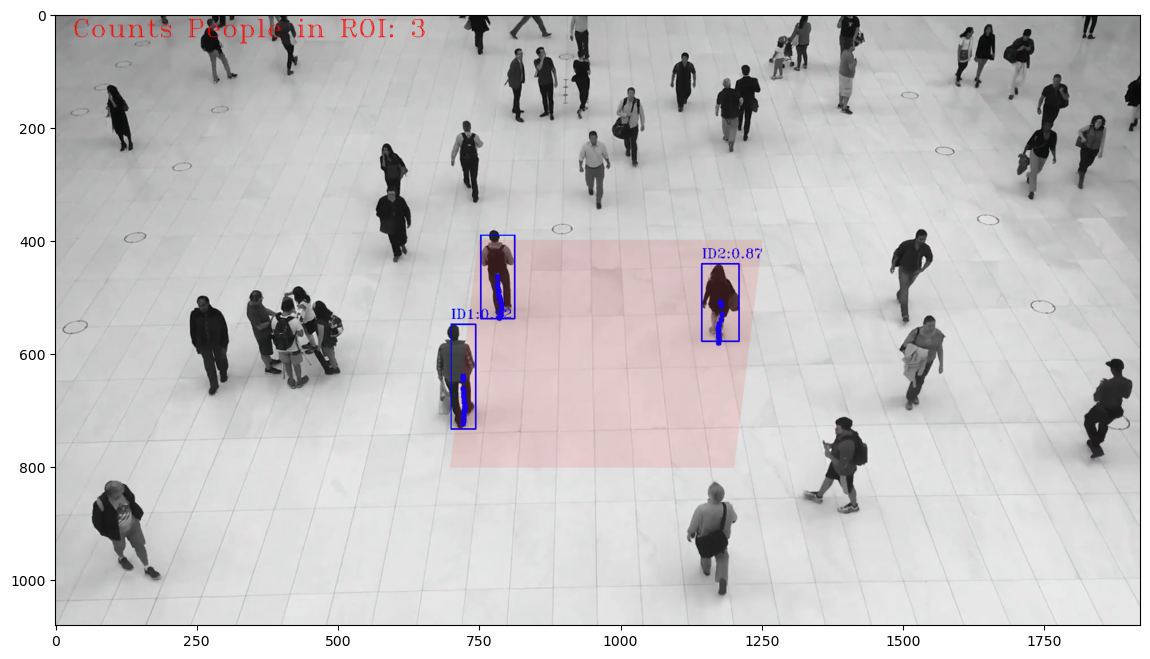

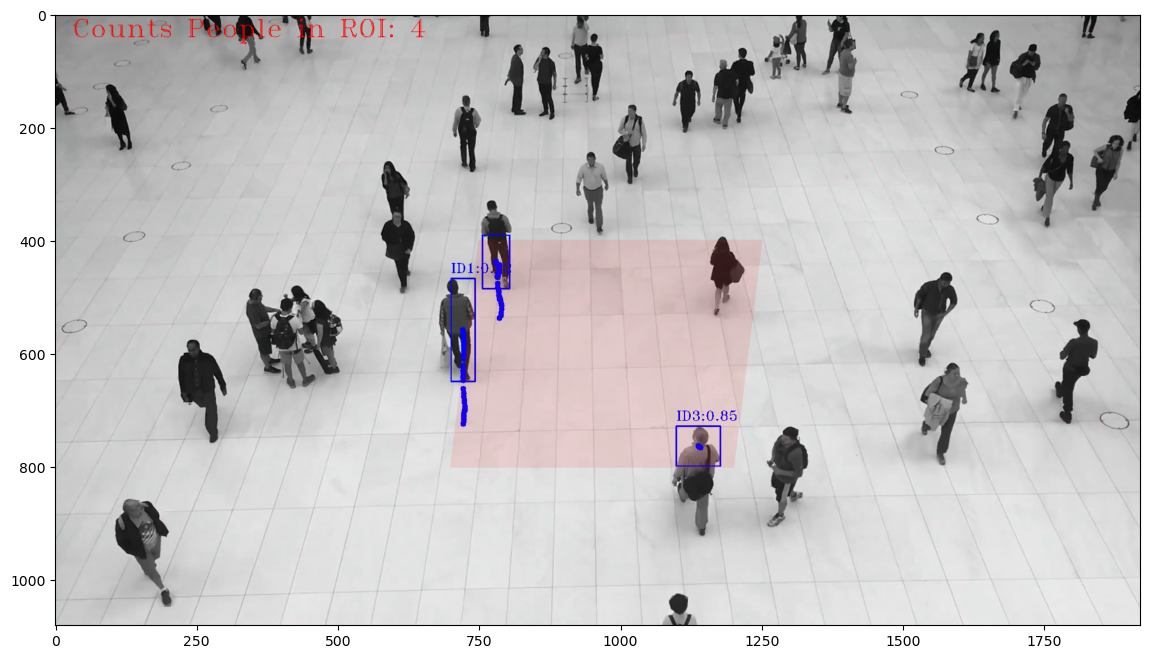

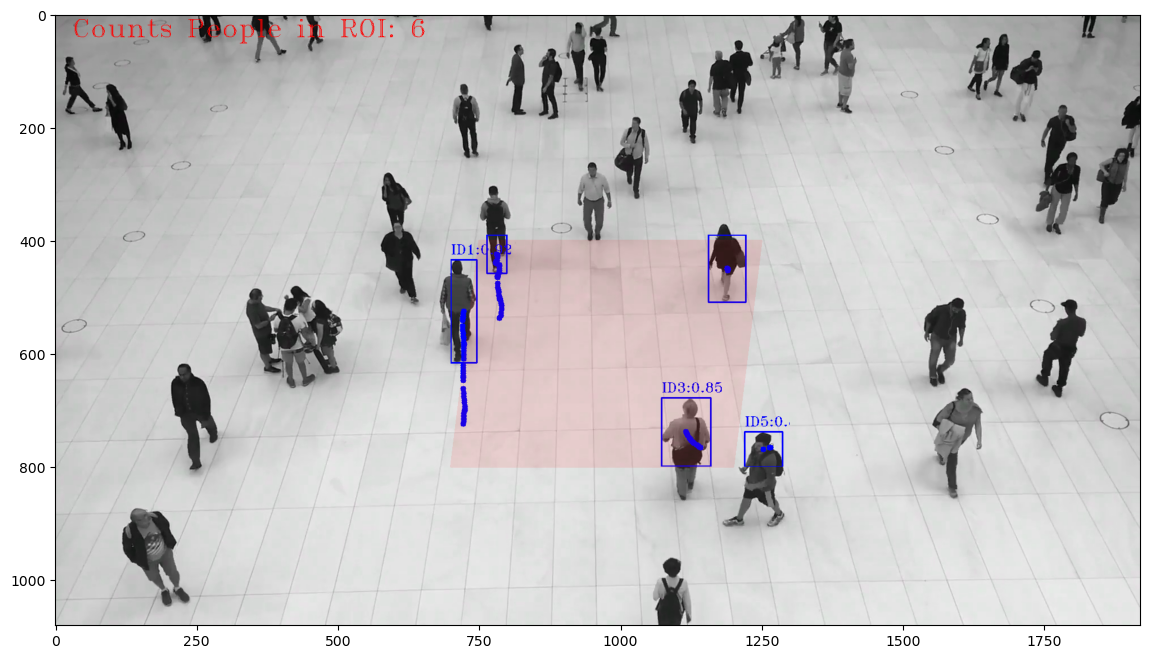

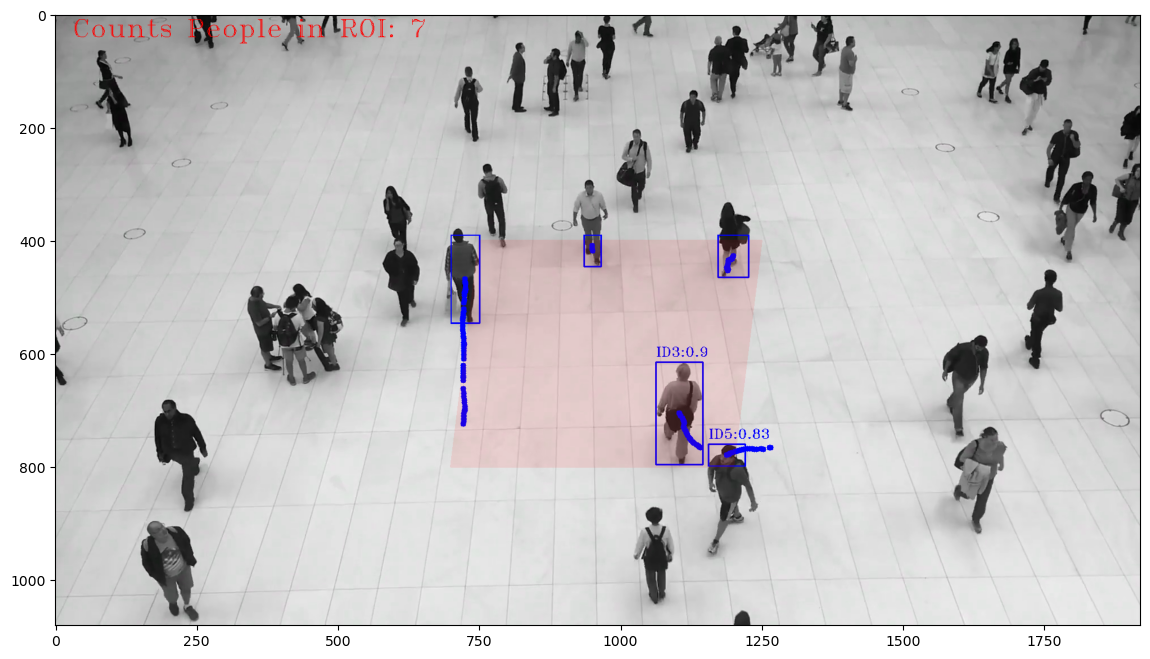

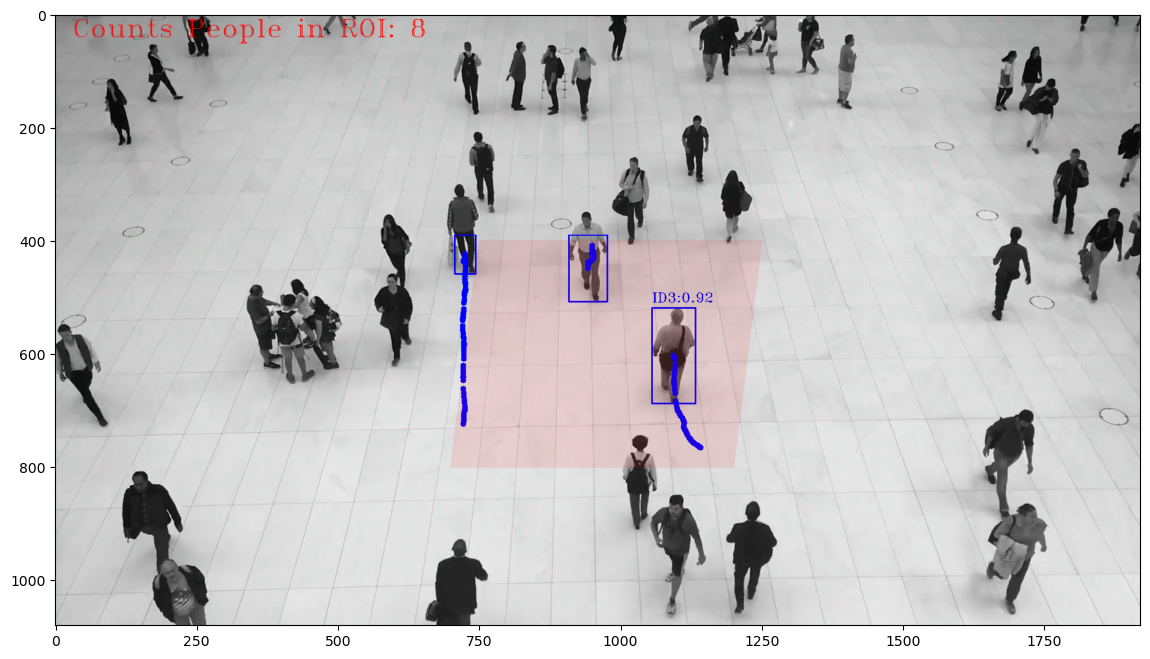

In [40]:
# Checking samples of processed frames
for i in [20, 40, 50, 65, 90]:
    plt.figure(figsize =( 14, 10))
    plt.imshow(frames_list[i])
    plt.show()

In [29]:
#output video result - in the SageMaker Studio might not work, therefore use the next cell using the HTML display method
frac = 0.2 
#Video(data='rep_result.mp4', embed=True, height=int(720 * frac), width=int(1280 * frac))

In [38]:
from IPython.display import HTML

HTML("""
    <video alt="test" controls>
        <source src="rep_result.mp4" type="video/mp4">
    </video>
""")